In [7]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import xml.etree.ElementTree as ET
from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

# Read data

In [8]:
annotations_dir = 'Data/annotations'
img_dir = 'Data/images'
img_lst = [] 
label_lst = []

In [10]:
for xml_files in os.listdir(annotations_dir):
    xml_file_path = os.path.join(annotations_dir,xml_files)
    tree = ET.parse(xml_file_path) 
    root = tree.getroot()
    filename = root.find("filename").text
    img_url = os.path.join(img_dir,filename)
    img = cv2.imread(img_url)
    
    # find the coordinates of traffic sign
    for obj in root.findall("object"):
        class_name = obj.find('name').text
        # because I only dectect traffic sign, I will ignore traffic light
        if class_name == 'trafficlight':
            continue
        xmin = int(obj.find("bndbox/xmin").text)
        xmax = int(obj.find("bndbox/xmax").text)
        ymin = int(obj.find("bndbox/ymin").text)
        ymax = int(obj.find("bndbox/ymax").text)
        
        obj_img = img[ymin:ymax,xmin:xmax]
        img_lst.append(obj_img)
        label_lst.append(class_name)
        
   
        
print("The number of objects: ",len(img_lst))
print("Class names: ",list(set(label_lst)))
    

The number of objects:  1074
Class names:  ['crosswalk', 'stop', 'speedlimit']


# Preprocessing

In [11]:
def preprocess_img(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
   
    img = img.astype(np.float32)
    resized_img = resize(img,output_shape=(32,32),anti_aliasing=True)
    hog_feature = feature.hog(
        resized_img,
        orientations = 9,
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        transform_sqrt=True, 
        block_norm="L2", 
        feature_vector=True
    )
    return hog_feature

In [12]:
# preprocess img
img_features_lst = []
for img in img_lst:
    hog_features = preprocess_img(img)
    img_features_lst.append(hog_features)
img_features_lst = np.array(img_features_lst)

# Encode Label

In [13]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)

# Split Data

In [14]:
random_state = 0 
test_size = 0.3 
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split( img_features_lst , encoded_labels , test_size=test_size ,
random_state=random_state ,
shuffle=is_shuffle )

# Normalize

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train Model

In [16]:
clf = SVC(kernel='rbf',random_state=random_state,probability=True,C = 0.5)
clf.fit(X_train,y_train)

SVC(C=0.5, probability=True, random_state=0)

# Evaluate Model

In [ ]:
y_pred = clf.predict(X_val)
score = accuracy_score(y_val,y_pred)
print("Accuracy = ",score)


Accuracy =  0.9907120743034056


# Localize Object

In [17]:
def sliding_window(img,window_sizes,stride,scale_factor):
    img_height,img_width = img.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_width, window_height = window_size
        for ymin in range(0,img_height - window_height +1,stride):
            for xmin in range(0,img_width - window_width +1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height
                # xmin = int(xmin/scale_factor)
                # xmax = int(xmax/scale_factor)
                # ymin = int(ymin/scale_factor)
                # ymax = int(ymax/scale_factor)
                windows.append([xmin,ymin,xmax,ymax])
    return windows

In [18]:
# use pyramid image technique that can detect small object
def pyramid(img,scale = 0.8,min_size = (30,30)):
    acc_scale = 1.0
    pyramid_imgs = [(img,acc_scale)]
    while True:
        acc_scale = acc_scale*scale
        h = int(img.shape[0]*acc_scale)
        w = int(img.shape[1]*acc_scale)
        if h < min_size[0] or w < min_size[1]:
            break
        img = cv2.resize(img,(w,h))
        pyramid_imgs.append((img,acc_scale))
    return pyramid_imgs

In [86]:
def visualize_bbox(img,bboxes,label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for box in bboxes:
        xmin,ymin,xmax,ymax,predicted_id,conf_score = box
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax)
        ymax = int(ymax)
        predicted_id = int(predicted_id)
        cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,0),2)
        classname = label_encoder.inverse_transform([predicted_id])[0]
        label = f"{classname} {conf_score:.2f}"
        (w,h),_ = cv2.getTextSize(label,cv2.FONT_HERSHEY_SIMPLEX,0.6,1)
        cv2.rectangle(img,(xmin,ymin-20),(xmin+w,ymin),(0,255,0),-1)
        cv2.putText(img,label,(xmin,ymin - 5),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),1)
        
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# To avoid the overlap of bounding boxes, we will use non-maximum suppression 
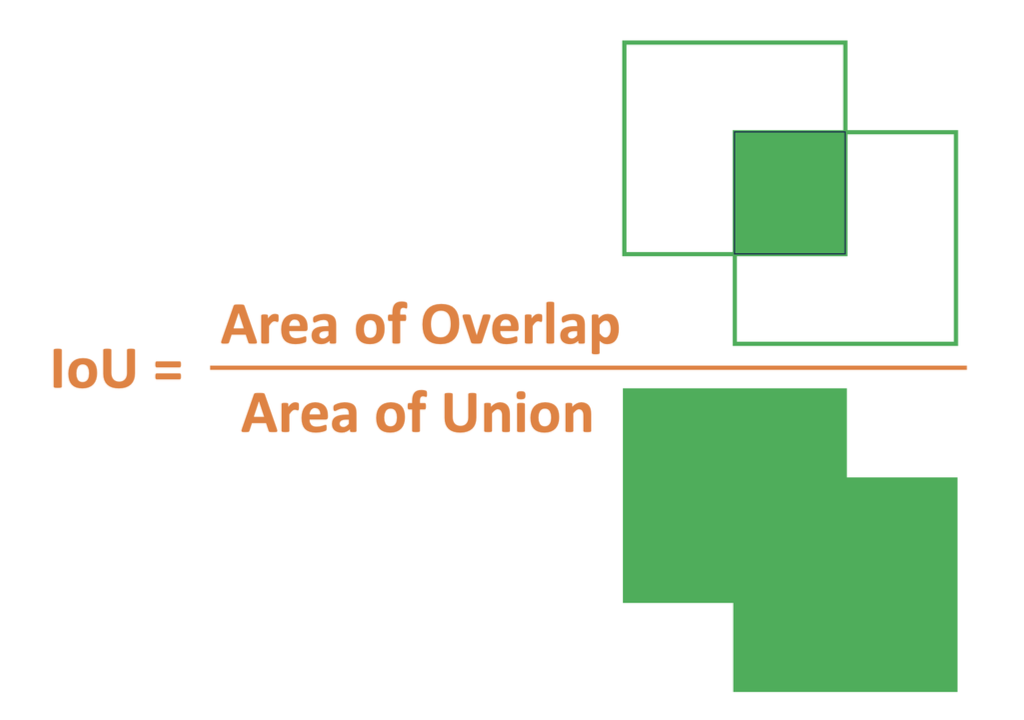

In [87]:
def compute_iou(bbox,bboxes,bbox_area,bboxes_area):
    xxmin = np.maximum(bbox[0],bboxes[:,0])
    yymin = np.maximum(bbox[1],bboxes[:,1])
    xxmax = np.minimum(bbox[2],bboxes[:,2])
    yymax = np.minimum(bbox[3],bboxes[:,3])
    w = np.maximum(0,xxmax - xxmin + 1)
    h = np.maximum(0, yymax - yymin + 1)
    intersection = w*h
    iou = intersection/(bbox_area + bboxes_area - intersection)

    return iou

def nms(bboxes,iou_threshold):
    if not bboxes:
        return []
    bboxes = np.array(bboxes)
    #xmin, ymin, xmax, ymax, predict_id, conf_score
    scores = bboxes[:,5]
    sorted_indices = np.argsort(scores)[::-1]
    xmin = bboxes[:,0]
    ymin = bboxes[:,1]
    xmax = bboxes[:,2]
    ymax = bboxes[:,3]
    areas = (xmax - xmin + 1) * (ymax - ymin + 1)
    keep = []
    while sorted_indices.size > 0:
        # get the idx of max conf
        i = sorted_indices[0]
        keep.append(i)
        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.array([
                    xmin[sorted_indices[1:]], 
                    ymin[sorted_indices[1:]], 
                    xmax[sorted_indices[1:]], 
                    ymax[sorted_indices[1:]]]
                    ).T,
            areas[i], 
            areas[sorted_indices[1:]]
        )
        idx_to_keep = np.where(iou < iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]
    return bboxes[np.array(keep)]
        
    
    

In [88]:

def predict_and_visualize(img,conf_score = 0.95,stride = 12,
                          window_sizes = [
                            (32,32),
                            (64,64),
                            (128,128)
                        ],iou_threshold = 0.2):


    start_time = time.time()
    bboxes = []
    pyramid_imgs = pyramid(img)

    for pyramid_img_info in pyramid_imgs:
        pyramid_imgs,scale_factor = pyramid_img_info
        window_lst = sliding_window(
            pyramid_imgs,
            window_sizes=window_sizes,
            stride = stride,
            scale_factor = scale_factor
        )
        
        for window in window_lst:
            xmin , ymin , xmax , ymax = window
            object_img = pyramid_imgs[ymin:ymax,xmin:xmax]
            # create hog feature
            preprocessed_img = preprocess_img(object_img)
            # normalize
            normalized_img = scaler.transform(preprocessed_img.reshape(1,-1))
            
            decision = clf.predict_proba(normalized_img)[0]
            
            if np.all(decision < conf_threshold): 
                continue
            else:
                predict_id = np.argmax(decision) 
                conf_score = decision[predict_id]   
                xmin = int(xmin / scale_factor) 
                ymin = int(ymin / scale_factor) 
                xmax = int(xmax / scale_factor) 
                ymax = int(ymax / scale_factor)
                bboxes.append([xmin, ymin, xmax, ymax, predict_id, conf_score] )
    bboxes = nms(bboxes,iou_threshold)
    
    visualize_bbox(img,bboxes,label_encoder)
        

In [89]:
import glob
urls = glob.glob(img_dir + '/*')


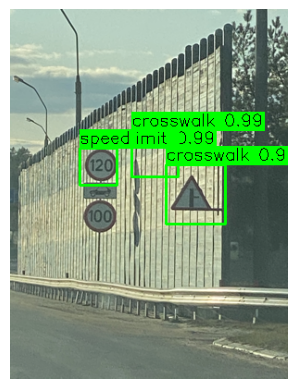

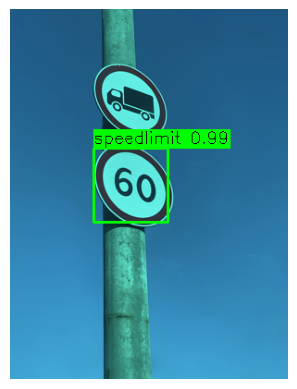

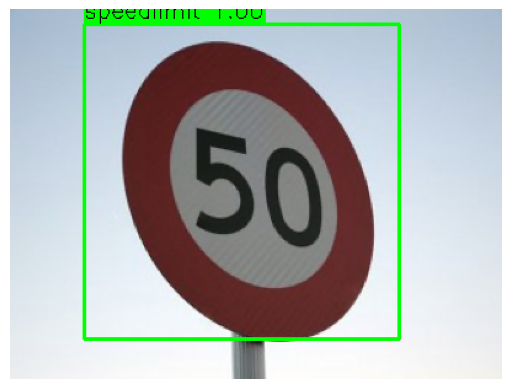

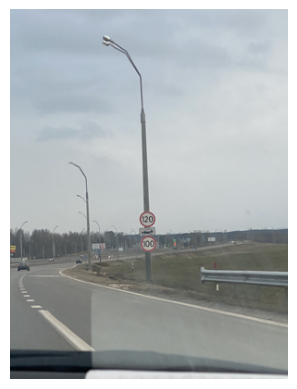

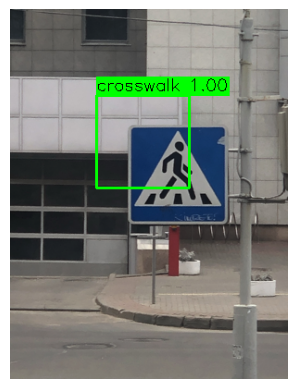

In [98]:

for i in range(5):
  img = cv2.imread(urls[i])


  predict_and_visualize(img,conf_score=0.8,iou_threshold = 0.2,
                        window_sizes = [

                              (8,8),
                              (16,16),
                              (32,32),
                              (64,64),
                              (128,128),
                              (256,256)
                          ]
                        )